In [ ]:
from phi4.implementation.lattice import Phi4Lattice
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
rng = np.random.default_rng(seed=42)  # Seed the r.n.g. for reproducible results (and errors!).
lattice = Phi4Lattice(linear_sites=5, mass2=-1.0, coupling_strength=8.0)
initial_sample = rng.random(size=lattice.shape)
samples, acceptances = lattice.sample(initial_field=initial_sample,
                                      num_samples=50_000,
                                      method='uniform',
                                      rng=rng,
                                      half_width=0.05)
samples = np.array(samples)
print(f"Acceptance is {np.mean(acceptances)*100:.2f}%" )
print("Typically, the optimal choice is around 60-70%.")

## Plot some configurations

In [ ]:
sample1 = samples[10_000]
sample2 = samples[40_000]

fig, (axis1, axis2) = plt.subplots(figsize=(14, 5), nrows=1, ncols=2)

image1 = axis1.imshow(sample1, cmap='plasma', interpolation=None)
axis1.set_xlabel(r"$x_{1}$", fontsize=16, labelpad=10)
axis1.set_ylabel(r"$x_{2}$", fontsize=16, rotation=0, labelpad=20)
cbar1 = fig.colorbar(image1, ax=axis1)
cbar1.set_label(r"$\phi$", fontsize=16, rotation=0, labelpad=10)

image2 = axis2.imshow(sample2, cmap='plasma', interpolation=None)
axis2.set_xlabel(r"$x_{1}$", fontsize=16, labelpad=10)
axis2.set_ylabel(r"$x_{2}$", fontsize=16, rotation=0, labelpad=20)
cbar2 = fig.colorbar(image2, ax=axis2)
cbar2.set_label(r"$\phi$", fontsize=16, rotation=0, labelpad=10)

plt.show()

## Exercise 1

Plot some field configurations and some random Gaussian noise.
What do you observe?

In [ ]:
field_sample = samples[40_000]
rng = np.random.default_rng(seed=42)
gauss_noise = rng.normal(loc=0.010694, scale=0.30215, size=field_sample.shape)

fig, (axis1, axis2) = plt.subplots(figsize=(14, 5), nrows=1, ncols=2)

image1 = axis1.imshow(field_sample, cmap='plasma', interpolation=None)
axis1.set_xlabel(r"$x_{1}$", fontsize=16, labelpad=10)
axis1.set_ylabel(r"$x_{2}$", fontsize=16, rotation=0, labelpad=20)
axis1.set_title("Field configuration", fontsize=16)
cbar1 = fig.colorbar(image1, ax=axis1)
cbar1.set_label(r"$\phi$", fontsize=16, rotation=0, labelpad=10)

image2 = axis2.imshow(gauss_noise, cmap='plasma', interpolation=None)
axis2.set_xlabel(r"$x_{1}$", fontsize=16, labelpad=10)
axis2.set_ylabel(r"$x_{2}$", fontsize=16, rotation=0, labelpad=20)
axis2.set_title("Gaussian noise", fontsize=16)
cbar2 = fig.colorbar(image2, ax=axis2)

plt.show()

## Evaluating an observable

Let's evaluate a simple observable
\begin{equation}
    \langle O(\phi) \rangle = \left\langle \left\lvert \frac{1}{V} \sum_{\mathbf{x}} \phi(\mathbf{x}) \right\rvert \right\rangle
\end{equation}

In [ ]:
observations1 = np.abs(np.sum(samples, axis=(1, 2)) / (lattice.linear_sites ** 2))

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(observations1)), observations1)
ax.set_xlabel("Monte Carlo step", fontsize=16, labelpad=10)
ax.set_ylabel(r"$O(\phi)$", fontsize=16, labelpad=10)
plt.show()

## Exercise 2: Tuning the MCMC

### Acceptance as a function of the lattice volume and half-width

A (very) rough estimate of the mean acceptance for a given lattice size $L = N^{2}$, with $N$ the number of sites per dimension, and half-width $h$ is given by
\begin{equation}
    (1 - 1.1 h) \cdot \exp{\left[ -0.37 h \cdot L^{1 - \exp{(-1.8 h^{0.13}})} \right]}
\end{equation}
Therefore, for a desired mean acceptance and one of $L$ or $h$, an approximated value for the remaining parameter can be found by obtaining the root of the above function.

In [ ]:
data = np.load("data/metro_mean_acceptances.npz")
acceptance_grid = data["acceptance_grid"]  # Each row is a specific lattice size, each column a half-width.
linear_sizes = data["linear_sizes"]
half_widths = data["half_widths"]
num_samples = data["num_samples"]

sizes_grid, widths_grid = np.meshgrid(linear_sizes, half_widths)

def acceptance_fit(volume, hw):
    return (1 - 1.1 * hw) * np.exp(-0.37 * hw * np.power(volume, 1 - np.exp(-1.8 * np.power(hw, 0.13))))

fit_grid = [np.array([acceptance_fit(linear_size ** 2, hw) for hw in half_widths])
            for linear_size in linear_sizes]
fit_grid = np.array(fit_grid)

In [ ]:
fig = plt.figure(figsize=(10, 6), layout='constrained')
ax = fig.add_subplot(projection='3d', elev=29., azim=31., roll=-3)
ax.scatter(sizes_grid ** 2, widths_grid, acceptance_grid, alpha=0.9, label="Data points")
ax.plot_wireframe(sizes_grid ** 2, widths_grid, fit_grid, color='r', label="Fitted grid")
ax.set_xlabel("Lattice size", fontsize=14, labelpad=7)
ax.set_ylabel("Half-width", fontsize=14, labelpad=7)
ax.set_zlabel("Mean acceptance", fontsize=14, labelpad=3)
plt.legend(fontsize=11)
plt.show()

## Exercise 3: Finite-volume effects

In [ ]:
linear_sizes = np.linspace(5, 50, num=20, endpoint=True, dtype=int)
half_widths = [0.0598, 0.0429, 0.0333, 0.0249, 0.0198,
               0.0188, 0.0147, 0.0136, 0.0123, 0.0105,
               0.0098, 0.0086, 0.0078, 0.0074, 0.0069,
               0.0063, 0.0054, 0.0052, 0.0050, 0.0045]
# num_samples = 500_000  # This allows thermalizing the largest lattice size.
sizes_observations = []

for linear_size, half_width in zip(linear_sizes, half_widths):
    print("Linear size:", linear_size)
    lattice = Phi4Lattice(linear_sites=linear_size, mass2=-1.0, coupling_strength=8.0)

    rng = np.random.default_rng(seed=42)
    initial_sample = rng.random(size=lattice.shape)
    samples, acceptance = lattice.sample(initial_field=initial_sample, num_samples=linear_size * 10_000,
                                         method='uniform', rng=rng, half_width=half_width)
    observations = np.abs(np.sum(samples, axis=(1, 2))) / (linear_size ** 2)
    sizes_observations.extend(observations)
    mean_acceptance = round(np.mean(acceptance), ndigits=2)
    print("Mean acceptance:", mean_acceptance)

np.savez("data/metro_sizes_observations.npz", sizes_observations=sizes_observations,
         linear_sizes=linear_sizes, half_widths=half_widths)

In [ ]:
obs_lengths = [10_000 * linear_size for linear_size in linear_sizes]
obs_slices = [(sum(obs_lengths[:idx]), sum(obs_lengths[:(idx + 1)])) for idx in range(len(obs_lengths))]
last_slice = obs_slices[-1]
my_observations = sizes_observations[last_slice[0]:last_slice[1]]

In [ ]:
len(my_observations)

In [ ]:
expectation_values = []
associated_errors = []

for my_idx in range(len(linear_sizes)):
    my_slice = obs_slices[my_idx]
    my_observations = sizes_observations[my_slice[0]:my_slice[1]]
    thermalization = len(my_observations) // 2
    my_observations = my_observations[thermalization:]
    n_steps = len(my_observations) // 100
    my_observations = my_observations[::n_steps]

    expectation_values.append(np.mean(my_observations))
    associated_errors.append(np.std(my_observations) / np.sqrt(len(my_observations)))

fig, ax = plt.subplots()
ax.errorbar(linear_sizes, expectation_values, yerr=associated_errors, fmt='o', markersize=4)
plt.show()

## Exercise 4: Phase transition

In [ ]:
linear_sizes = np.linspace(5, 50, num=20, endpoint=True, dtype=int)
half_widths = [0.0598, 0.0429, 0.0333, 0.0249, 0.0198,
               0.0188, 0.0147, 0.0136, 0.0123, 0.0105,
               0.0098, 0.0086, 0.0078, 0.0074, 0.0069,
               0.0063, 0.0054, 0.0052, 0.0050, 0.0045]
mass2_values = [-1.0 * i for i in range(16)]

idx = 5
linear_size = linear_sizes[idx]
half_width = 0.955 * half_widths[idx]

initial_samples = np.load("data/metro_ex4_initial_states1.npz")["initial_states"]

mass2_observations = []

for idx, mass2 in enumerate(mass2_values):
    lattice = Phi4Lattice(linear_sites=linear_size, mass2=mass2, coupling_strength=8.0)
    rng = np.random.default_rng(seed=42)
    samples, acceptance = lattice.sample(initial_field=initial_samples[idx],
                                         num_samples=linear_size * 30_000,
                                         method='uniform', rng=rng, half_width=half_width,
                                         progress_bar=False)
    observations = np.abs(np.sum(samples, axis=(1, 2))) / (linear_size ** 2)
    mass2_observations.append(observations)
    print(f"Mass squared: {mass2}. Mean acceptance: {np.mean(acceptance):.2f}")
    half_width = 0.95 * half_width  # Reduce the half-width for the next iteration to fix acceptance.

In [ ]:
thermalization = 40_000
x_values = list(range(linear_size * 30_000))

for my_idx in range(len(mass2_values)):
    fig, ax = plt.subplots()
    y_values = mass2_observations[my_idx]

    ax.plot(x_values, y_values, label=f'Mass squared: {mass2_values[my_idx]}')
    ax.plot(x_values[thermalization:], y_values[thermalization:])
    plt.legend()
    plt.show()

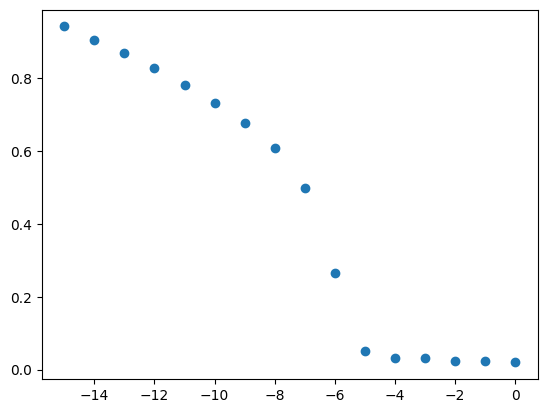

In [10]:

fig, ax = plt.subplots()
ax.scatter(mass2_values, [np.mean(mass2_observations[idx][::(linear_size * 30_000) // 1_000])
                       for idx in range(len(mass2_values))])
plt.show()

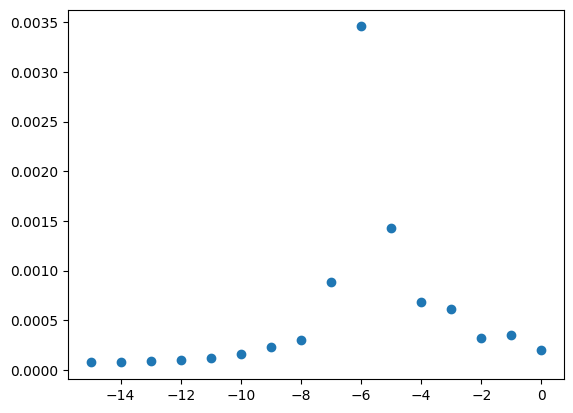

In [11]:
fig, ax = plt.subplots()
ax.scatter(mass2_values, [np.var(mass2_observations[idx][::(linear_size * 30_000) // 1_000])
                       for idx in range(len(mass2_values))])
plt.show()